### Create Synthetic Datasets
---

This notebook is used to generate simple sinusoidal synthetic datasets with a specified numbers of worms, labeled neurons, and other characteristics of real datasets.

**Last update:** _13 May 2024_

#### Import libraries & modules
---

In [1]:
import torch
import pickle
import random
import tiktoken
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from openai import OpenAI
from omegaconf import OmegaConf
from typing import Protocol, Union
from scipy.integrate import solve_ivp
from transformers import AutoTokenizer
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset as load_hf_dataset
from tokenizers.pre_tokenizers import WhitespaceSplit
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NUM_TOKENS, NUM_NEURONS, NEURON_LABELS, init_random_seeds

# Initialize the random seeds
init_random_seeds(42)

CUDA device found.
	 GPU: NVIDIA A100 80GB PCIe


##### Helper functions
___

In [2]:
def plot_neural_signals(data, time_tensor, neuron_idx=None, yax_limit=True, suptitle=None):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(0), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert neuron_idx <= num_neurons, "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert len(neuron_idx) <= num_neurons, "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(12, num_columns))
    fig.tight_layout(pad=0.0)

    # If num_columns is 1, make ax iterable by wrapping it in a list
    if num_columns == 1:
        axs = [axs]

    # Now your existing loop should work without modification
    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("{}".format(NEURON_LABELS[column_indices[i]]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time (s)")

    # Add a super title to the figure if provided
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad=1)

    plt.show()

In [3]:
def plot_3d_trajectory(X, axis_labels=("Time", "Value", "Z Axis"), title="Trajectory", show=True):
    """
    Plot a trajectory from a dataset, which can be 1D, 2D, or 3D.

    Parameters:
    - X: A 2D numpy array containing the trajectory data. Must be shaped as (time, features).
    - axis_labels: A tuple containing the labels for the axes. Default is ('Time', 'Value', 'Z Axis').
    - title: Title of the plot.
    - show: If True, the plot will be displayed. If False, the plot object will be returned.

    Returns:
    - fig, ax: The figure and axis objects of the plot if show is False.
    """
    max_timesteps = X.shape[0]
    dims = X.shape[1] if len(X.shape) > 1 else 1

    # Create a new figure for the plot
    fig = plt.figure(figsize=(12, 12))
    if dims >= 3:
        ax = fig.add_subplot(111, projection="3d")
        plot_dims = 3
    else:
        ax = fig.add_subplot(111)
        plot_dims = dims

    # Create a color map based on the time progression
    norm = plt.Normalize(0, max_timesteps)
    colors = plt.cm.viridis(norm(np.arange(max_timesteps)))

    # Extract coordinates from the data and plot accordingly
    if plot_dims == 1:
        x = np.arange(max_timesteps)
        y = X.flatten()
        z = np.zeros(max_timesteps)
        ax_labels = (axis_labels[0], "Value", "Fixed Z")
        # Plot the 1D trajectory with a color gradient
        for i in range(1, max_timesteps):
            ax.plot(x[i - 1 : i + 1], y[i - 1 : i + 1], color=colors[i], lw=0.5)
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], "ro", markersize=7)  # End with a red circle
    elif plot_dims == 2:
        # Pick two random columns to plot
        ind_x, ind_y = np.random.choice(X.shape[1], 2, replace=False)
        x, y = X[:, ind_x], X[:, ind_y]
        z = np.zeros(max_timesteps)
        ax_labels = (axis_labels[0], axis_labels[1], "Fixed Z")
        # Plot the 2D trajectory
        for i in range(1, max_timesteps):
            ax.plot(x[i - 1 : i + 1], y[i - 1 : i + 1], color=colors[i], lw=0.5)
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], "ro", markersize=7)  # End with a red circle
    else:  # plot_dims == 3
        ind_x, ind_y, ind_z = np.random.choice(X.shape[1], 3, replace=False)
        x, y, z = X[:, ind_x], X[:, ind_y], X[:, ind_z]
        ax_labels = axis_labels
        # Plot the 3D trajectory
        for i in range(1, max_timesteps):
            ax.plot(
                x[i - 1 : i + 1],
                y[i - 1 : i + 1],
                z[i - 1 : i + 1],
                color=colors[i],
                lw=0.5,
            )
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], z[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], z[-1], "ro", markersize=7)  # End with a red circle

    # Set labels for the axes
    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1])
    if plot_dims == 3:
        ax.set_zlabel(ax_labels[2])

    # Set title
    ax.set_title(title)

    # Show the plot
    if show:
        plt.show()
    else:
        return fig, ax

In [4]:
def lorenz_attractor(t, X, sigma=10, beta=8 / 3, rho=28):
    """The Lorenz equations.
    NOTE: This is an autonomus/time-invariant system becuase the right-hand side
            of the differential equations do not depend explicitly on time, t.
    """
    x, y, z = X
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

In [5]:
def van_der_pol_oscillator(t, X, mu=1.0):
    """The Van der Pol oscillator equations.
    NOTE: This is an autonomus/time-invariant system becuase the right-hand side
        of the differential equations do not depend explicitly on time, t.
    """
    x, y = X
    dx_dt = y
    dy_dt = mu * (1 - x**2) * y - x
    return [dx_dt, dy_dt]

In [6]:
class SinusoidsOscillator:
    def __init__(self, sum_freqs=0, random=True):
        self.eps = np.finfo(float).eps
        # number of frequencies summed to create a frequency fingerprint
        self.sum_freqs = sum_freqs
        self.random = random
        # create frequencies and phases
        if self.random:  # use random frequencies
            self.freqs = np.round(self.eps + np.random.random(self.sum_freqs) / 10, 4)
        else:  # use deterministic frequencies
            self.freqs = np.round(
                np.arange(1 / (2 * self.sum_freqs + self.eps), self.sum_freqs)
                / (10 * self.sum_freqs),
                4,
            )
        # always use random phases
        self.phases = np.random.random(self.sum_freqs) * 2 * np.pi

    def __call__(self, t, Y):
        y = Y
        # the leak term -y ensures convergence to a fixed point if no external input is provided
        dy_dt = -y + sum(np.cos(2 * np.pi * f * t + p) for f, p in zip(self.freqs, self.phases))
        return dy_dt

In [7]:
def save_synthetic_dataset(file_name, dataset):
    with open(file_name, "wb") as f:
        pickle.dump(dataset, f)

In [10]:
def pre_tokenize_and_chunk(texts, max_length=510):
    """
    Pre-tokenize and chunk the text into segments of a specified maximum length.

    Args:
        texts (list of str): List of strings.
        max_length (int): Maximum length of each chunk.

    Returns:
        list: A list of text chunks.
    """
    joined_text = " ".join(texts)
    pre_tokenizer = WhitespaceSplit()
    pre_tokens = pre_tokenizer.pre_tokenize_str(joined_text)

    chunks = []
    current_chunk = ""
    for token, (start, end) in pre_tokens:
        if len(current_chunk) + len(token) + 1 > max_length:
            chunks.append(current_chunk.strip())
            current_chunk = token
        else:
            current_chunk += " " + token if current_chunk else token
    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks

In [11]:
def tokenize_and_chunk(texts, tokenizer, max_length=512):
    """
    Tokenize and chunk texts.

    Args:
        texts (list of str): Input texts.
        tokenizer: Tokenizer instance.
        max_length (int): Max length (in chars) string to tokenize.

    Returns:
        dict: Dictionary containing text and token ids.
    """
    text = []
    input_ids = []
    chunks = pre_tokenize_and_chunk(texts, max_length - 2)  # adjust for special tokens
    for chunk in chunks:
        text.append(chunk)  # each chunk is a string shorter than max_length characters
        tokens = tokenizer.encode(chunk)  # returns a list of integers
        input_ids.append(tokens)
    text_and_tokens = {"text": text, "input_ids": input_ids}
    return text_and_tokens

In [12]:
def get_embedding(text, model="text-embedding-3-small", dimensions=NUM_TOKENS):
    """
    We can ue OpenAI's Embeddings API to get embeddings directly from text to embeddings.
    This is shorter than tokenizing the text first followed by using an embedding layer.
    The OpenAI Embeddings model directly converts an entire string (i.e. chunk of text)
    into a single embedding vector.
    """
    client = OpenAI()
    if isinstance(text, list):
        assert isinstance(text[0], str), "List of strings expected."
        text = [string.replace("\n", " ") for string in text]
        input = text
    else:
        assert isinstance(text, str), "String expected."
        text = text.replace("\n", " ")
        input = [text]
    data = client.embeddings.create(input=input, model=model, dimensions=dimensions).data
    result = [
        np.array(d.embedding) for d in data
    ]  # list of array; each array is an embedding vector
    return result

#### Define some tokenizers to experiment with

In [1]:
HF_TOKENIZER = AutoTokenizer.from_pretrained("google/byt5-large")
BASE_TOKENIZER = tiktoken.get_encoding("cl100k_base")
GPT4_TOKENIZER = tiktoken.encoding_for_model("gpt-4")


class TokenizerProtocol(Protocol):
    """
    We define a simple common interface that all
    tokenizers to be used in our code must implement.
    """

    def encode(self, text: str) -> dict: ...


# # # ##### DEBUG: Going straight from text chunks to embeddings using OpenAI's Embeddings model #####
# tokenizer = BASE_TOKENIZER
# text_dataset = load_hf_dataset("wikitext", "wikitext-2-v1")
# text_dataset = tokenize_and_chunk(text_dataset["train"]["text"], tokenizer)
# chunks = pre_tokenize_and_chunk(text_dataset["text"], max_length=64)
# embdeddings = get_embedding(chunks[:10]) # restrict to 10 API calls
# print()
# print(f"embeddings array: {np.array(embdeddings).shape}\n")
# print(f"embeddings tensor: {torch.tensor(embdeddings).shape}\n")
# # # ##################################################################################################################

NameError: name 'AutoTokenizer' is not defined

#### Some default parameter values from config files

In [1]:
config = OmegaConf.load("../configs/submodule/preprocess.yaml")
DELTA_T = config.preprocess.resample_dt

NameError: name 'OmegaConf' is not defined

#### Wikitext dataset

In [16]:
def create_synthetic_dataset_wikitext(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = NUM_NEURONS,
    num_labeled_neurons: Union[None, int] = None,
    add_noise: bool = False,
    noise_std: float = 0.01,
    random_walk: bool = False,
    # >>> any special arguments for this function should go here >>>
    use_openai: bool = False,
    tokenizer: Union[None, TokenizerProtocol] = None,
    # <<< any special arguments for this function should go here <<<
    delta_seconds: float = DELTA_T,
    smooth_method: Union[None, str] = "exponential",
    transform: Union[None, callable] = StandardScaler(),
    dataset_name: str = "Wikitext0000",
):
    """
    TODO: Write a comprehensive docstring.
    The main idea here is to treat the embeddings of a 1D sequence of tokens
    as if it was a multi-dimensional time series of neural activity.
    """
    eps = np.finfo(float).eps
    dataset = {}
    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # column vector
    # Calculate number of named and unlabeled neurons
    if num_labeled_neurons is None or num_labeled_neurons > num_signals:  # default to all neurons
        num_labeled_neurons = num_signals
    elif num_labeled_neurons < 0:  # default to no neurons
        num_labeled_neurons = 0
    num_unlabeled_neurons = num_signals - num_labeled_neurons
    # Initializae the tokenizer and set vocab_size attribute
    if tokenizer is None:
        tokenizer = BASE_TOKENIZER
    if isinstance(tokenizer, tiktoken.core.Encoding):
        tokenizer.vocab_size = tokenizer.n_vocab
    # Load the WikiText dataset
    text_dataset = load_hf_dataset("wikitext", "wikitext-2-v1")
    # Process and tokenize just the train split
    text_dataset = tokenize_and_chunk(text_dataset["train"]["text"], tokenizer, max_length=256)
    # Create a fixed embedding map from tokens to embedding vectors
    embed_dim = num_signals
    # Random initialization of embeddings using normal distribution
    embedding_weights = torch.randn(tokenizer.vocab_size, embed_dim)
    torch.nn.init.normal_(embedding_weights, mean=0.0, std=1.0)
    num_tokens = embedding_weights.shape[0]
    assert isinstance(embedding_weights, torch.Tensor) and embedding_weights.shape == (
        num_tokens,
        embed_dim,
    ), f"embedding_weight must be a PyTorch tensor of shape ({num_tokens}, {embed_dim})"
    # Create fixed embedding layer / table
    embedding = torch.nn.Embedding(
        num_embeddings=num_tokens,
        embedding_dim=embed_dim,
        dtype=torch.half,
        _weight=embedding_weights,
        _freeze=True,
    )
    # Create combined dataset of the embedded token sequences from the train split
    if use_openai:
        text_chunks = pre_tokenize_and_chunk(text_dataset["text"], max_length=64)
        max_size = 1 + max_timesteps * num_worms  # restricts the number of API calls
        combo_embd_chunks = get_embedding(text_chunks[:max_size], dimensions=embed_dim)
    else:
        combo_embd_chunks = [
            embedding(torch.LongTensor(sequence)).detach().numpy()
            for sequence in text_dataset["input_ids"]
        ]
    # Create data for as many worms as possible if not enough data
    worm_idx = 0
    calcium_data = []  # will be shaped (time, neurons)
    total_time = 0
    # Keep growing a sequence of embeddings until we reach the maximum timesteps
    for chunk in combo_embd_chunks:
        # Reshape to a row vector if necessary
        if chunk.ndim == 1:
            chunk = chunk.reshape(1, -1)
        # If we have enough worms break out of the loop
        if worm_idx >= num_worms:
            break
        # Otherwise continue extending the calcium data
        calcium_data.append(chunk)
        total_time += chunk.shape[0]
        # Preprocess calcium data once enough timesteps have been created
        if total_time >= max_timesteps:
            calcium_data = np.vstack(calcium_data)[:max_timesteps]
            # Choose a random subset of neurons to record / observe / measure
            labeled_neuron_indices = random.sample(
                range(num_signals), num_labeled_neurons
            )  # without replacement
            labeled_neurons = set(NEURON_LABELS[i] for i in labeled_neuron_indices)
            # Create neuron to idx mapping and vice versa
            neuron_to_idx = {
                (neuron) if neuron in labeled_neurons else str(idx): idx
                for idx, neuron in enumerate(NEURON_LABELS)
            }
            idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}
            # Zero out non-recorded / "unobserved" neurons
            if num_labeled_neurons < num_signals:
                unlabeled_neuron_indices = np.array(
                    [idx for idx in range(num_signals) if idx not in labeled_neuron_indices]
                )
                calcium_data[:, unlabeled_neuron_indices] *= 0.0
            # Add i.i.d measurement/observation noise
            if add_noise:
                for neuron_index in labeled_neuron_indices:
                    if random_walk:
                        noise_walk = np.cumsum(
                            [0]
                            + np.random.normal(
                                loc=0, scale=noise_std, size=max_timesteps - 1
                            ).tolist()
                        )
                        calcium_data[:, neuron_index] += noise_walk
                    else:
                        noise_iid = np.random.normal(0, noise_std, max_timesteps)
                        calcium_data[:, neuron_index] += noise_iid
            # Normalize data
            if transform:
                calcium_data = transform.fit_transform(calcium_data)
            # Calculate residuals
            dt = np.diff(time_in_seconds, axis=0, prepend=0.0)
            resample_dt = np.median(dt[1:]).item()
            residual_calcium = np.gradient(calcium_data, time_in_seconds.squeeze(), axis=0)
            # Smooth the data and convert to tensors
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data,
                time_in_seconds,
                smooth_method,
                **dict(alpha=0.5, window_size=15, sigma=5),
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium,
                time_in_seconds,
                smooth_method,
                **dict(alpha=0.5, window_size=15, sigma=5),
            )
            # Initialize worm data
            worm = f"worm{worm_idx}"
            worm_data = dict()
            # Save the data
            worm_data["worm"] = worm
            worm_data["source_dataset"] = dataset_name
            worm_data["smooth_method"] = smooth_method
            worm_data["calcium_data"] = calcium_data
            worm_data["smooth_calcium_data"] = smooth_calcium_data
            worm_data["residual_calcium"] = residual_calcium
            worm_data["smooth_residual_calcium"] = smooth_residual_calcium
            worm_data["max_timesteps"] = max_timesteps
            worm_data["time_in_seconds"] = time_in_seconds
            worm_data["dt"] = dt
            worm_data["median_dt"] = resample_dt
            worm_data["neuron_to_idx"] = neuron_to_idx
            worm_data["idx_to_neuron"] = idx_to_neuron
            worm_data["num_neurons"] = num_signals
            worm_data["num_labeled_neurons"] = num_labeled_neurons
            worm_data["num_unlabeled_neurons"] = num_unlabeled_neurons
            worm_data["extra_info"] = {
                "embedding_weights": embedding_weights,
                "num_tokens": num_tokens,
                "use_openai": use_openai,
                "measurement_noise": add_noise,
                "iid_noise_std": noise_std * int(add_noise),
                "meta_text": "This dataset simulates neural activity data as the embedding vectors of language tokens using some fixed, "
                "pre-specified embedding table given by `embedding_weights`. If `use_openai` is True, then the OpenAI Embeddings model "
                "was used to generate the emebeddings rather than the `embedding_weights`.\n"
                "The boolean `measurement_noise` indicates whether i.i.d Gaussian noise with mean 0 and variance `iid_noise_std`^2 was added to the observed 'neural' data.\n",
            }
            # Reshape the data to the standardized format
            worm_data = reshape_calcium_data(worm_data)
            # Save the data
            dataset[worm] = worm_data
            # Increment the worm index and reset the calcium data and timestep counter
            worm_idx += 1
            calcium_data = []
            total_time = 0
    return dataset

In [ ]:
# Initialize parameters
max_timesteps = 1000
num_worms = 10
num_signals = NUM_NEURONS
# Reflect a cost-benefit tradeoff between throughput and accuracy
num_labeled_neurons = num_signals - num_worms + 1
add_noise = False  # measurement noise
noise_std = 0.01
random_walk = False
use_openai = False
tokenizer = BASE_TOKENIZER
delta_seconds = DELTA_T
smooth_method = None
transform = StandardScaler()
dataset_name = "Wikitext0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_wikitext(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_labeled_neurons=num_labeled_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    use_openai=use_openai,
    tokenizer=tokenizer,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Get the number of worms in the dataset
num_worms = len(dataset)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

#### Created helper code for plotting that gets repeatedly called throughout this notebook

In [21]:
def thunk():
    global num_worms, worm_idx, neuron_idx
    # Selecting a worm and all the neurons to plot
    num_worms = len(dataset)
    worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
    neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][:num_labeled_neurons]

    # Plotting dataset
    plot_neural_signals(
        data=dataset[worm_idx]["calcium_data"],
        time_tensor=dataset[worm_idx]["time_in_seconds"],
        neuron_idx=neuron_idx,
        yax_limit=False,
        suptitle=f"{dataset_name} - {worm_idx}",
    )

    # Visualize covariance matrix
    data = dataset[worm_idx]["calcium_data"]
    mask = dataset[worm_idx]["labeled_neurons_mask"]
    neurons = sorted(dataset[worm_idx]["labeled_neuron_to_slot"])

    # X = data[:, mask].numpy()
    # n = X.shape[0]
    # # centering the data here is redundant if StandardScaler was used when creating the dataset
    # X_bar = X - np.mean(X, axis=0, keepdims=True)
    # cov = 1 / (n - 1) * X_bar.T @ X_bar

    # plt.figure()
    # ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
    # ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
    # plt.show()

    # # Plotting 3D trajectory
    # plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

    ### DEBUG ###
    V = data.numpy()
    n = V.shape[0]
    # Centering the data here is redundant if StandardScaler was used when creating the dataset
    V_bar = V - np.mean(V, axis=0, keepdims=True)
    cov = 1 / (n - 1) * V_bar.T @ V_bar
    X = V[:, mask.numpy()]

    heat_mask = (mask.unsqueeze(1).numpy() * 1) @ (mask.unsqueeze(0).numpy() * 1)
    heat_mask = ~heat_mask.astype(bool)
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    cmap.set_bad(color="black")  # Set the color for NaN values

    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(
        cov, cmap=cmap, mask=heat_mask, xticklabels=NEURON_LABELS, yticklabels=NEURON_LABELS
    )
    # Adjust the font size of x and y tick labels
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=4)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=4)
    ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
    plt.show()

    # Plotting 3D trajectory
    plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")
    ### DEBUG ###

In [ ]:
# Plotting the dataset
thunk()

##### Key insights

What if real calcium fluorescence signals (our proxy for neural activity/state) that we measure from neurons are just smoothed (i.e low-pass filtered) embeddings of some underlying but unknown 1-D token sequence? 

What would be the interpetation of this 1-D sequence? - could this be "behavior"; some more general notion of "state" that is finite (i.e fixed vocabulary size)? 

Can we invert the embeddings to figure out what this 1-D sequence was? Notice there is no smooth transition in the embeddings when viewed as a time series. This is because there is no semantic relationship between consecutive embeddings vectors since we just initialized them randomly. 

Does training of embeddings make their dynamics smooth?

TODO: Look at `EmbeddingsOpenAI.ipynb`.

#### Sines dataset
---

In [ ]:
def create_synthetic_dataset_sines(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = NUM_NEURONS,
    num_labeled_neurons: Union[None, int] = None,
    add_noise: bool = False,
    noise_std: float = 0.01,
    random_walk: bool = False,
    # >>> any special arguments for this function should go here >>>
    sum_frequencies: int = 1,
    random_freqs: bool = False,
    # <<< any special arguments for this function should go here <<<
    delta_seconds: float = 0.5,
    smooth_method: Union[None, str] = "exponential",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler(), #CausalNormalizer() #None
    dataset_name: str = "Sines0000",
):
    """
    Create a synthetic worm datasets using a sum of sinusoidal functions.
    Out of the `num_signals` neurons, `num_labeled_neurons` neurons are chosen randomly
    to have non-zero (i.e. "measured") signals. Each neuron's calcium signal is a sinusoid
    with `sum_frequencies` frequencies added together and a random phase. Each neuron class
    has a distinct frequency fingerprint (i.e. the particular frequencies summed together).

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_labeled_neurons: The number of measured neurons to create non-zero signals for.
    :param add_noise: Whether to simulate measurement noise by adding Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the i.i.d Gaussian measurement noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param random_freqs: If True, use random frequencies for each neuron. Otherwise, use the same frequencies for all neurons.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}
    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # column vector
    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # consistent across worms
    # Calculate number of named and unlabeled neurons
    if num_labeled_neurons is None or num_labeled_neurons > num_signals:  # default to all neurons
        num_labeled_neurons = num_signals
    elif num_labeled_neurons < 0:  # default to no neurons
        num_labeled_neurons = 0
    num_unlabeled_neurons = num_signals - num_labeled_neurons
    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # varies across worms
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        # Choose a random subset of neurons to record / observe / measure
        labeled_neuron_indices = random.sample(
            range(num_signals), num_labeled_neurons
        )  # without replacement
        labeled_neurons = set(NEURON_LABELS[i] for i in labeled_neuron_indices)
        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in labeled_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURON_LABELS)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}
        # Create calcium data
        for neuron_index in labeled_neuron_indices:
            neuron_name = NEURON_LABELS[neuron_index]
            # Each neuron class has a distinct and deterministic frequency fingerprint
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                (
                    np.round(
                        eps + np.random.random(sum_frequencies) / 10, 4
                    ).tolist()  # random frequencies
                    if random_freqs
                    else np.round(
                        np.arange(1 / (2 * sum_frequencies + eps), sum_frequencies)
                        / (10 * sum_frequencies),
                        4,
                    ).tolist()
                ),  # deterministic frequencies
            )
            # All neuron classes have a distinct but random phase offset
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [np.random.random() * 2 * np.pi for _ in range(sum_frequencies)],  # random phase
            )
            time_points = np.arange(max_timesteps)
            # Add sine functions together to create the simulated calcium signal
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, neuron_index] += np.sin(2 * np.pi * freq * time_points + phase)
            # Add i.i.d measurement/observation noise
            if add_noise:
                if random_walk:
                    noise_walk = np.cumsum(
                        [0]
                        + np.random.normal(loc=0, scale=noise_std, size=max_timesteps - 1).tolist()
                    )
                    calcium_data[:, neuron_index] += noise_walk
                else:
                    noise_iid = np.random.normal(0, noise_std, max_timesteps)
                    calcium_data[:, neuron_index] += noise_iid
        # Normalize the data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)
        # Calculate residuals
        dt = np.diff(time_in_seconds, axis=0, prepend=0.0)
        resample_dt = np.median(dt[1:]).item()
        residual_calcium = np.gradient(calcium_data, time_in_seconds.squeeze(), axis=0)
        # Smooth the data and convert to tensors
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method, **dict(alpha=0.5, window_size=15, sigma=5)
        )
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium,
            time_in_seconds,
            smooth_method,
            **dict(alpha=0.5, window_size=15, sigma=5),
        )
        # Build the dataset
        worm_data["worm"] = worm
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["num_neurons"] = num_signals
        worm_data["num_labeled_neurons"] = num_labeled_neurons
        worm_data["num_unlabeled_neurons"] = num_unlabeled_neurons
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["median_dt"] = resample_dt
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["extra_info"] = {
            "neuron_to_frequencies": neuron_to_frequencies,
            "neuron_to_phases": neuron_to_phases,
            "measurement_noise": add_noise,
            "iid_noise_std": noise_std * int(add_noise),
            "meta_text": "This dataset simulates neural activity data as the sum of sinusoidal functions with distinct frequency and phase fingerprints for each neuron class.\n"
            "The 'fingerprint' for each neuron class is the particular set deterministic frequencies that are summed to give that neuron's signal and each neuron class has a distinct but random phase offset.\n"
            "The boolean `measurement_noise` indicates whether i.i.d Gaussian noise with mean 0 and variance `iid_noise_std`^2 was added to the observed 'neural' data.\n",
        }
        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)
        # Save the data
        dataset[worm] = worm_data
    return dataset

In [ ]:
# Initialize parameters
max_timesteps = 1000
num_worms = 100
num_signals = NUM_NEURONS
# Reflect a cost-benefit tradeoff between throughput and accuracy
num_labeled_neurons = num_signals - num_worms + 1
add_noise = False  # measurement noise
noise_std = 0.1
random_walk = False
sum_frequencies = 1  # single frequency per fingerprint
random_freqs = True
delta_seconds = DELTA_T
smooth_method = None
transform = StandardScaler()
dataset_name = "Sines0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_labeled_neurons=num_labeled_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    sum_frequencies=sum_frequencies,
    random_freqs=random_freqs,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Plotting the dataset
thunk()

### Dynamics datasets
___

We attempt to generalize the previous approaches to generating synthetic data from arbitrary dynamical systems.

In [17]:
def create_synthetic_dataset_dynamics(
    dynamics_func: callable,
    state_dim: int,
    func_args: tuple = (),
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = NUM_NEURONS,
    num_labeled_neurons: Union[None, int] = None,
    add_noise: bool = False,
    noise_std: float = 0.01,
    random_walk: bool = False,
    delta_seconds: float = 1.0,
    smooth_method: Union[None, str] = "exponential",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler(), #CausalNormalizer() #None
    dataset_name: str = "Dynamics0000",
):
    """
    Create a synthetic worm dataset using a user-defined dynamical system.

    Parameters:
    :param dynamics_func: The function defining the dynamics, with function signature like (t, y, *args).
    :param state_dim: The dimension of the state vector y to the dynamics function.
    :param func_args: Any extra arguments to pass to the dynamics function.
    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_labeled_neurons: The number of measured neurons to create non-zero signals for.
    :param add_noise: Whether to simulate measurement noise by adding Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the i.i.d Gaussian measurement noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.

    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}

    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # Column vector

    # Calculate number of named and unlabeled neurons
    if num_labeled_neurons is None or num_labeled_neurons > num_signals:  # default to all neurons
        num_labeled_neurons = num_signals
    elif num_labeled_neurons < 0:  # default to no neurons
        num_labeled_neurons = 0
    num_unlabeled_neurons = num_signals - num_labeled_neurons

    # Add a warmup period to allow the system to reach a steady state
    warmup_timesteps = max_timesteps // 6
    simulation_steps = max_timesteps + warmup_timesteps

    # Create a readout that transforms from latent variables to measured neurons
    num_latent_vars = state_dim

    # Distinct neuron classes will represent a distinct linear combination of the variable
    projection_matrix = np.random.randn(
        num_labeled_neurons, num_latent_vars
    )  # consistent across worms

    # Normalize the rows to have norm-1
    projection_matrix = projection_matrix / np.linalg.norm(projection_matrix, axis=1, keepdims=True)

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Choose a random subset of neurons to record / observe / measure
        labeled_neuron_indices = random.sample(
            range(num_signals), num_labeled_neurons
        )  # without replacement
        labeled_neurons = set(NEURON_LABELS[i] for i in labeled_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in labeled_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURON_LABELS)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Define a new set of initial conditions for each worm
        initial_conditions = np.random.uniform(low=-5.0, high=5.0, size=num_latent_vars).tolist()

        # Integrate the Lorenz system with different initial conditions
        sol = solve_ivp(
            fun=dynamics_func,
            y0=initial_conditions,
            t_span=[0, simulation_steps],
            t_eval=time_in_seconds.squeeze() + warmup_timesteps,
            args=func_args,
        )
        latent_trajectories = sol.y  # (num_latent_vars, max_timesteps)

        # Transform to the measured neurons
        measured_trajectories = (
            projection_matrix @ latent_trajectories
        )  # (num_labeled_neurons,  max_timesteps)

        # Fill in the calcium data at measured locations
        calcium_data[:, labeled_neuron_indices] = measured_trajectories.T

        # Add i.i.d measurement/observation noise
        if add_noise:
            for neuron_index in labeled_neuron_indices:
                if random_walk:
                    noise_walk = np.cumsum(
                        [0]
                        + np.random.normal(loc=0, scale=noise_std, size=max_timesteps - 1).tolist()
                    )
                    calcium_data[:, neuron_index] += noise_walk
                else:
                    noise_iid = np.random.normal(0, noise_std, max_timesteps)
                    calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.diff(time_in_seconds, axis=0, prepend=0.0)
        resample_dt = np.median(dt[1:]).item()
        residual_calcium = np.gradient(calcium_data, time_in_seconds.squeeze(), axis=0)

        # Smooth the data and convert to tensors
        smooth_calcium_data = smooth_data_preprocess(calcium_data, time_in_seconds, smooth_method)
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Build the dataset
        worm_data["worm"] = worm
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["num_neurons"] = num_signals
        worm_data["num_labeled_neurons"] = num_labeled_neurons
        worm_data["num_unlabeled_neurons"] = num_unlabeled_neurons
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["median_dt"] = resample_dt
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["extra_info"] = {
            "projection_matrix": projection_matrix,
            "measurement_noise": add_noise,
            "iid_noise_std": noise_std * int(add_noise),
            "num_latent_vars": num_latent_vars,
            "latent_trajectories": latent_trajectories.T,
            "meta_text": "This dataset simulates neural activity data as a projection or readout of some low-dimensional dynamical system.\n"
            "Each neuron class is a distinct linear combination of the latent variables of the underlying dynamical system.\n"
            "The matrix `latent_trajectories` stores the dynamics of the underlying latent variables used to generate the neural data.\n"
            "The boolean `measurement_noise` indicates whether i.i.d Gaussian noise with mean 0 and variance `iid_noise_std`^2 was added to the observed neural data.\n",
        }

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

#### Lorenz dataset
---

In [ ]:
# Initialize parameters
dynamics_func = lorenz_attractor
state_dim = 3
func_args = ()
max_timesteps = 1000
num_worms = 100
num_signals = NUM_NEURONS
# Reflect a cost-benefit tradeoff between throughput and accuracy
num_labeled_neurons = num_signals - num_worms + 1
add_noise = False  # measurement noise
noise_std = 0.01
random_walk = False
delta_seconds = DELTA_T / 10  # need small dt for ODE integration
smooth_method = None
transform = StandardScaler()
dataset_name = "Lorenz0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_labeled_neurons=num_labeled_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

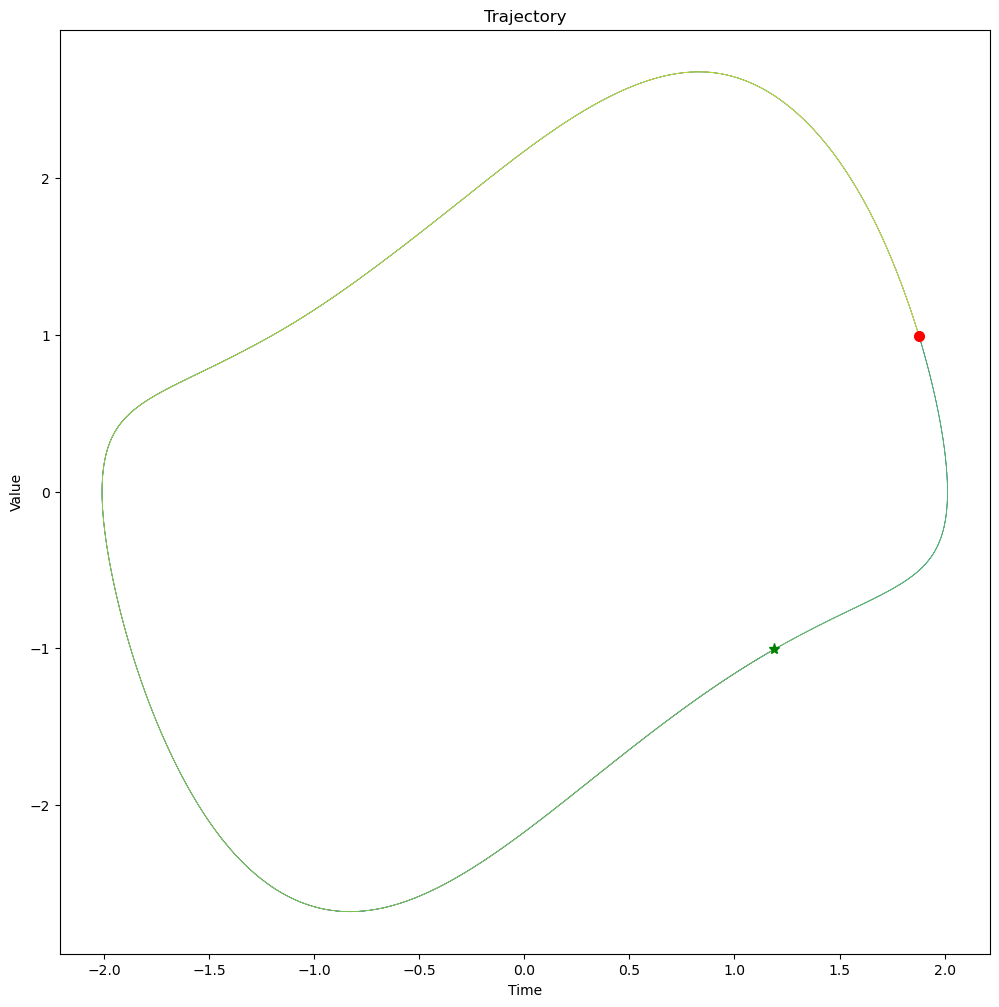

In [22]:
### DEBUG ###
d = dataset["worm0"]["extra_info"]["latent_trajectories"]
plot_3d_trajectory(d)
### DEBUG ###

In [ ]:
# Plotting the dataset
thunk()

### Van Der Pol dataset
___

In [18]:
# Initialize parameters
dynamics_func = van_der_pol_oscillator
state_dim = 2
func_args = ()
max_timesteps = 1000
num_worms = 100
num_signals = NUM_NEURONS
# Reflect a cost-benefit tradeoff between throughput and accuracy
num_labeled_neurons = num_signals - num_worms + 1
add_noise = False  # measurement noise
noise_std = 0.01
random_walk = False
delta_seconds = DELTA_T / 10  # need small dt for ODE integration
smooth_method = None
transform = StandardScaler()
dataset_name = "VanDerPol0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_labeled_neurons=num_labeled_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

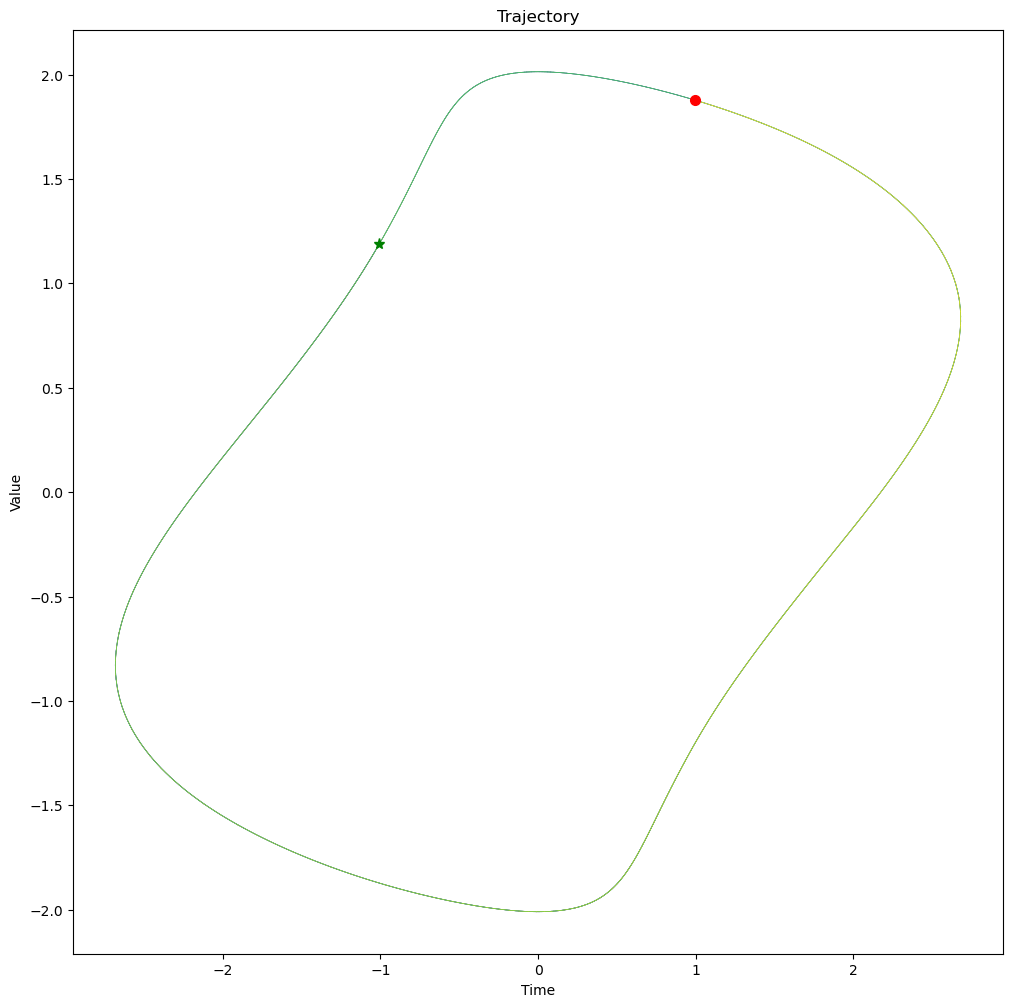

In [19]:
### DEBUG ###
d = dataset["worm0"]["extra_info"]["latent_trajectories"]
plot_3d_trajectory(d)
### DEBUG ###

In [20]:
# Plotting the dataset
thunk()

NameError: name 'thunk' is not defined

In [ ]:
# Check if neurons consistent across anoteher worm
thunk()

### Random Walk dataset
___

In [ ]:
# Initialize parameters
sinusoids_oscillator = SinusoidsOscillator(sum_freqs=0, random=True)  # dynamical system instance
dynamics_func = sinusoids_oscillator
state_dim = 1
func_args = ()
max_timesteps = 1000
num_worms = 100
num_signals = NUM_NEURONS
# Reflect a cost-benefit tradeoff between throughput and accuracy
num_labeled_neurons = num_signals - num_worms + 1
add_noise = True  # measurement noise
noise_std = 0.01
random_walk = True
delta_seconds = DELTA_T / 10  # need small dt for ODE integration
smooth_method = None
transform = StandardScaler()
dataset_name = "RandWalk0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_labeled_neurons=num_labeled_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Plotting the dataset
thunk()

### White Noise dataset
---

In [ ]:
# Define the parameters
sinusoids_oscillator = SinusoidsOscillator(sum_freqs=0, random=True)  # dynamical system instance
dynamics_func = sinusoids_oscillator
state_dim = 1
func_args = ()
max_timesteps = 1000
num_worms = 100
num_signals = NUM_NEURONS
# Reflect a cost-benefit tradeoff between throughput and accuracy
num_labeled_neurons = num_signals - num_worms + 1
add_noise = True  # measurement noise
noise_std = 0.01
random_walk = False
delta_seconds = DELTA_T / 10  # need small dt for ODE integration
smooth_method = None
transform = StandardScaler()
dataset_name = "WhiteNoise0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_labeled_neurons=num_labeled_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Plotting the dataset
thunk()